### Loading data

In [17]:
import yfinance as yf

def get_price_data(ticker):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2023-10-22')
    return tickerDf.iloc[:, :5]

apple_df = get_price_data('AAPL')
nike_df = get_price_data('NKE')

Apple and Nike stocks time series

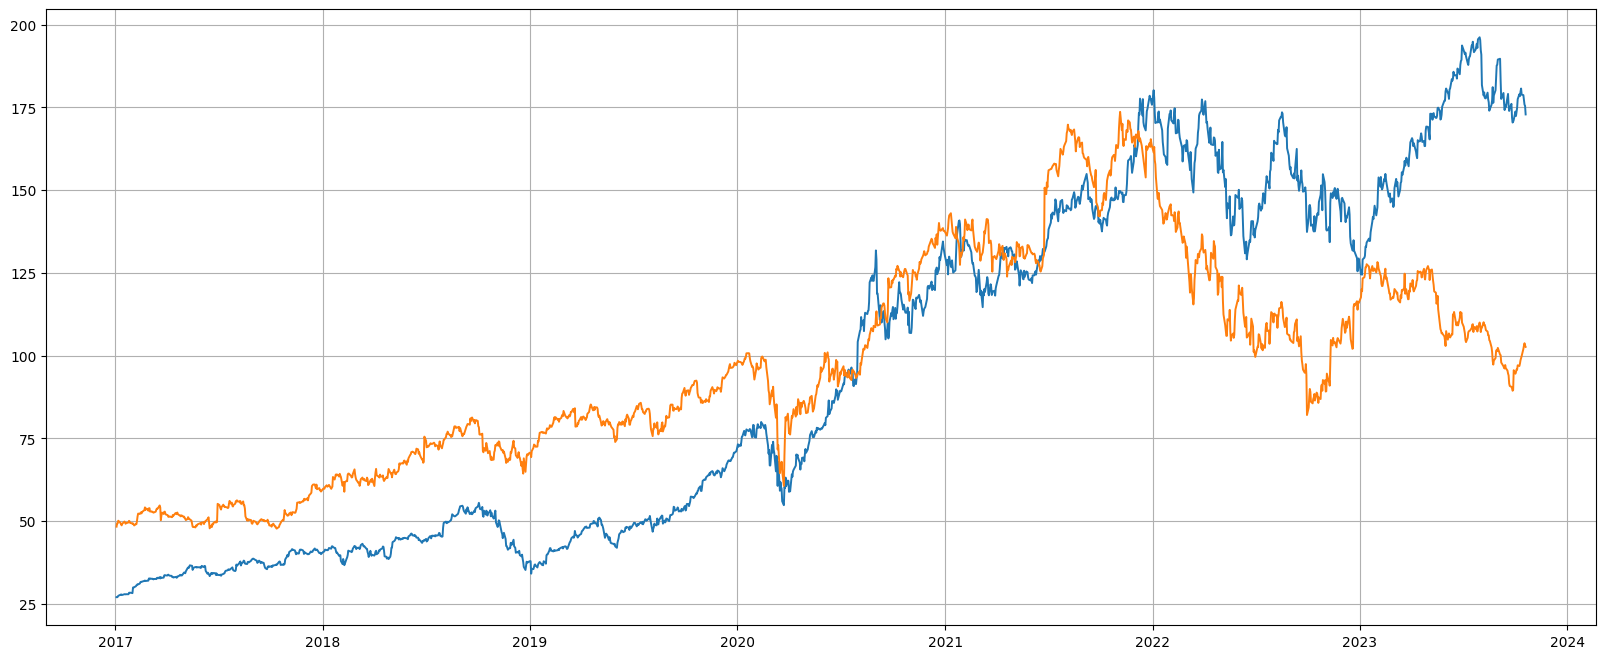

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.plot(apple_df['Close'], linewidth=1.4)
plt.plot(nike_df['Close'], linewidth=1.4)
plt.grid(True)
plt.show()

### Checking stationary of time series

Will use Dickey–Fuller test to check stationary. We should transform time series to stationary to make predictions more precise

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import warnings 

warnings.filterwarnings('ignore')

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Apple time series results

Results of Dickey-Fuller Test:
Test Statistic                   -0.630383
p-value                           0.863968
#Lags Used                       18.000000
Number of Observations Used    1693.000000
Critical Value (1%)              -3.434218
Critical Value (5%)              -2.863249
Critical Value (10%)             -2.567680
dtype: float64


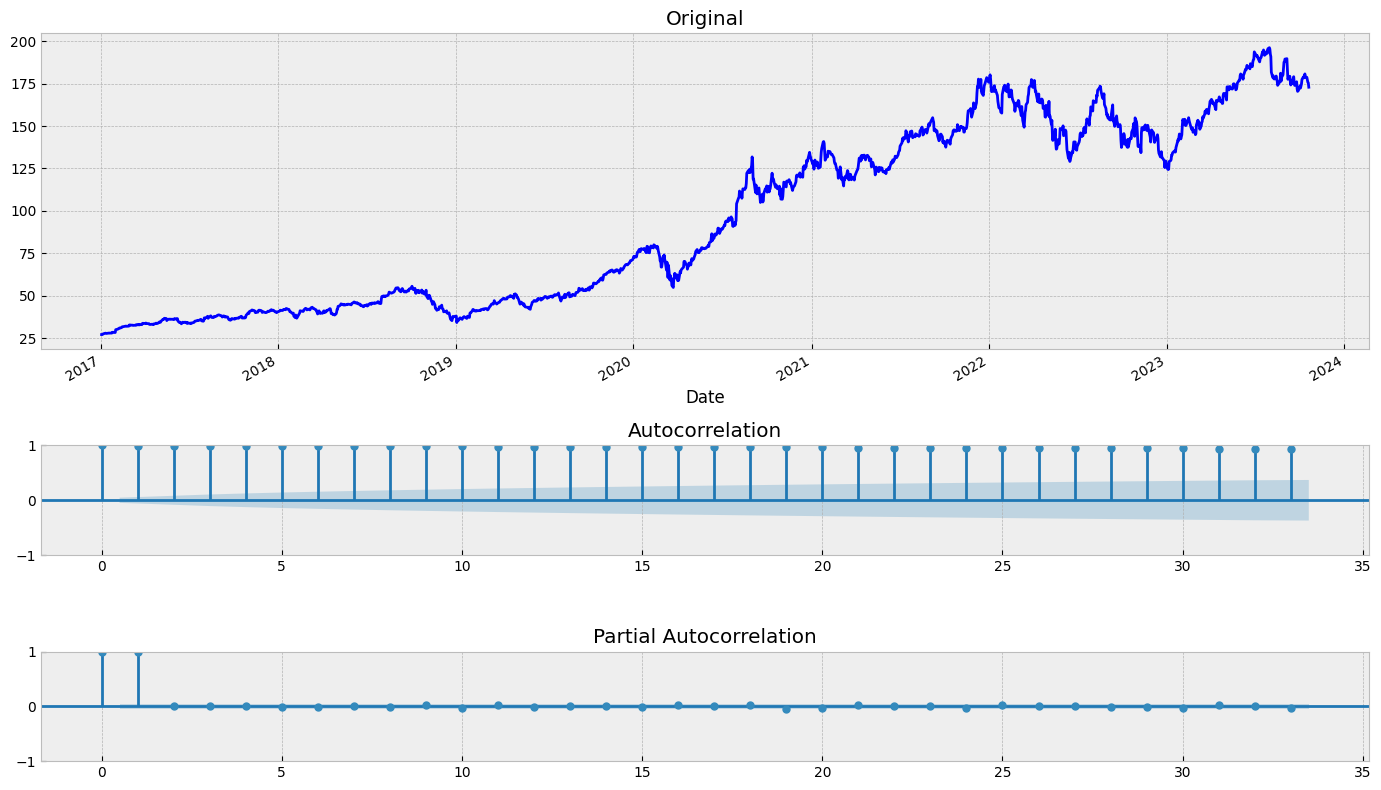

In [20]:
series = apple_df['Close']
tsplot(series)

According to the results of test our time series is not stationary. Autocorrelation graphs indicate the presence of trends and seasonal fluctuations in the series. Let's try to perform the Box-Cox transformation to stabilize the dispersion of the time series.

Results of Dickey-Fuller Test:
Test Statistic                   -1.229931
p-value                           0.660590
#Lags Used                        9.000000
Number of Observations Used    1702.000000
Critical Value (1%)              -3.434198
Critical Value (5%)              -2.863240
Critical Value (10%)             -2.567675
dtype: float64


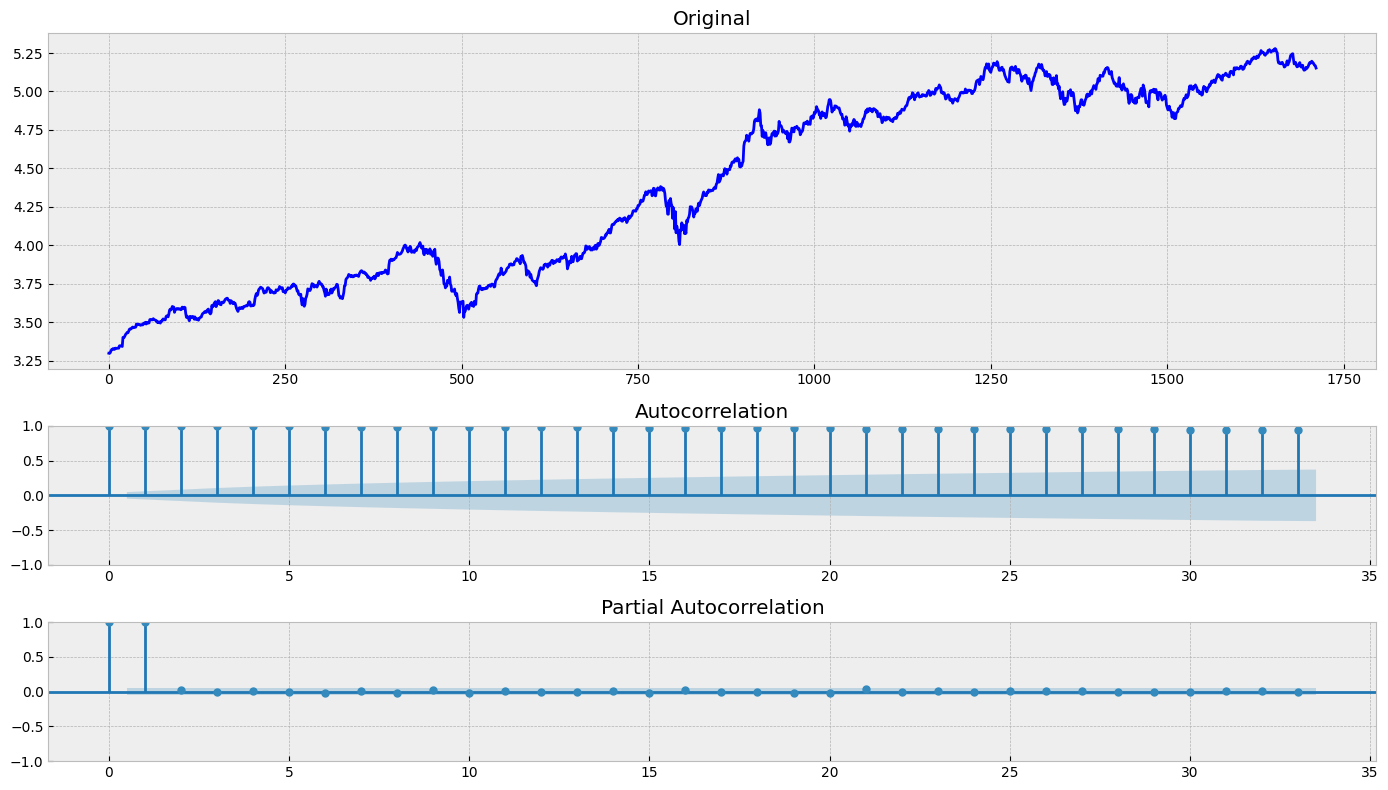

In [21]:
series = boxcox(series, 0)
tsplot(series)

The graph shows that the range of sample values is reduced, but there is a strong trend. You can try to remove it by integration.

Results of Dickey-Fuller Test:
Test Statistic                -1.294896e+01
p-value                        3.408324e-24
#Lags Used                     8.000000e+00
Number of Observations Used    1.702000e+03
Critical Value (1%)           -3.434198e+00
Critical Value (5%)           -2.863240e+00
Critical Value (10%)          -2.567675e+00
dtype: float64


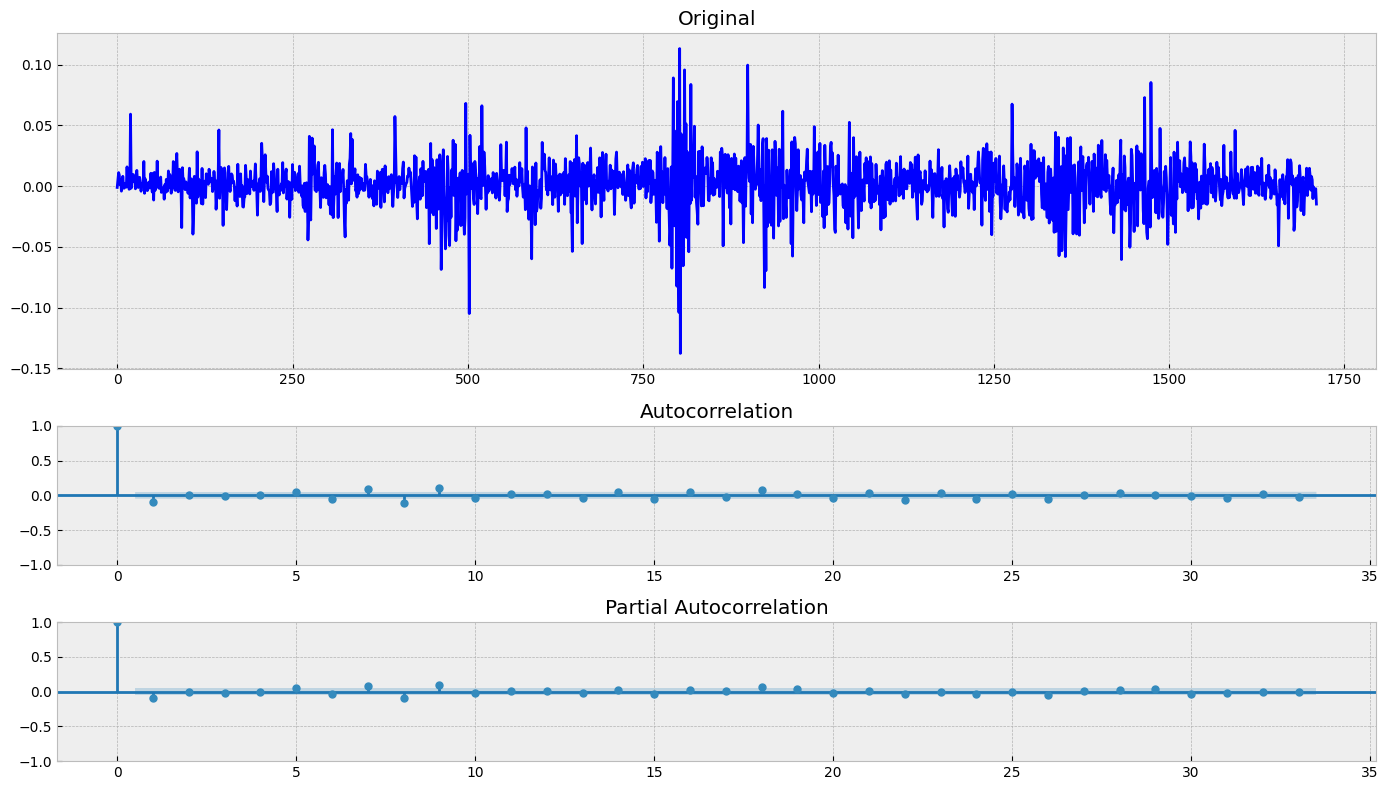

In [22]:
series = series[1:] - series[:-1]
tsplot(series)

The original series was brought to stationary by applying the Box-Cox transformation and first-order integration.

Let's perform the same manipulations with the Nike time series.

Results of Dickey-Fuller Test:
Test Statistic                -1.030914e+01
p-value                        3.219571e-18
#Lags Used                     1.500000e+01
Number of Observations Used    1.695000e+03
Critical Value (1%)           -3.434214e+00
Critical Value (5%)           -2.863247e+00
Critical Value (10%)          -2.567679e+00
dtype: float64


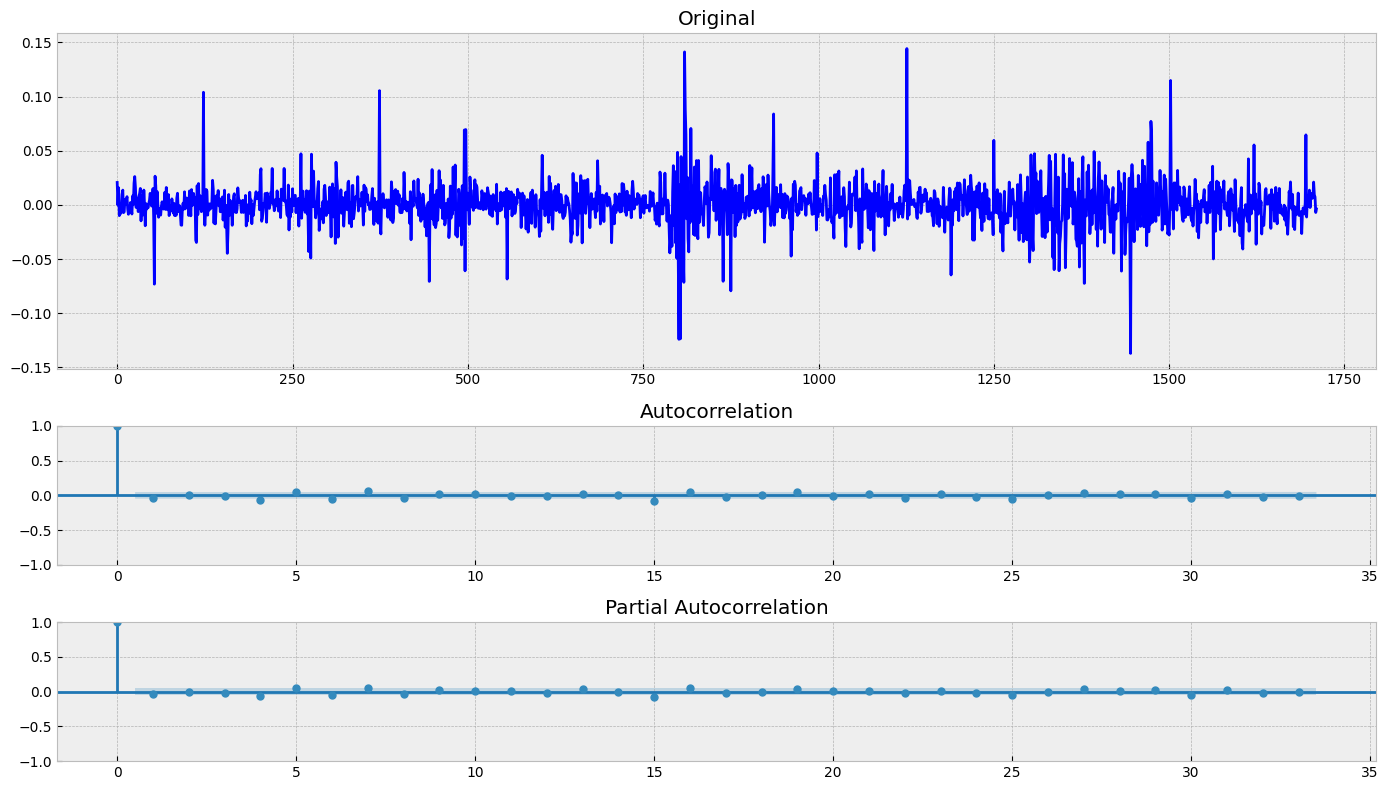

In [23]:
series = nike_df['Close']
series = boxcox(series, 0)
series = series[1:] - series[:-1]
tsplot(series)

### Time series normality

In [24]:
import seaborn as sns
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan,
                                   het_goldfeldquandt,
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant
from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval < 0.05 else 'Not Normal'

def print_result(data,color):
    normal_args = (np.mean(data),np.std(data))

    print('Test1: ', is_normal(shapiro(data)))
    print('Test2: ', is_normal(normaltest(data)))
    print('Test3: ', is_normal(normal_ad(data)))
    print('Test4: ', is_normal(kstest_normal(data)))
    print('Test5: ', is_normal(kstest(data,
                   cdf='norm',
                   args=normal_args)))
    
    sns.histplot(data=data, kde=True, color=color).set(title='Гистограмма временного ряда');

Let's check the values of the Apple time series for normality by performing a series of tests

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


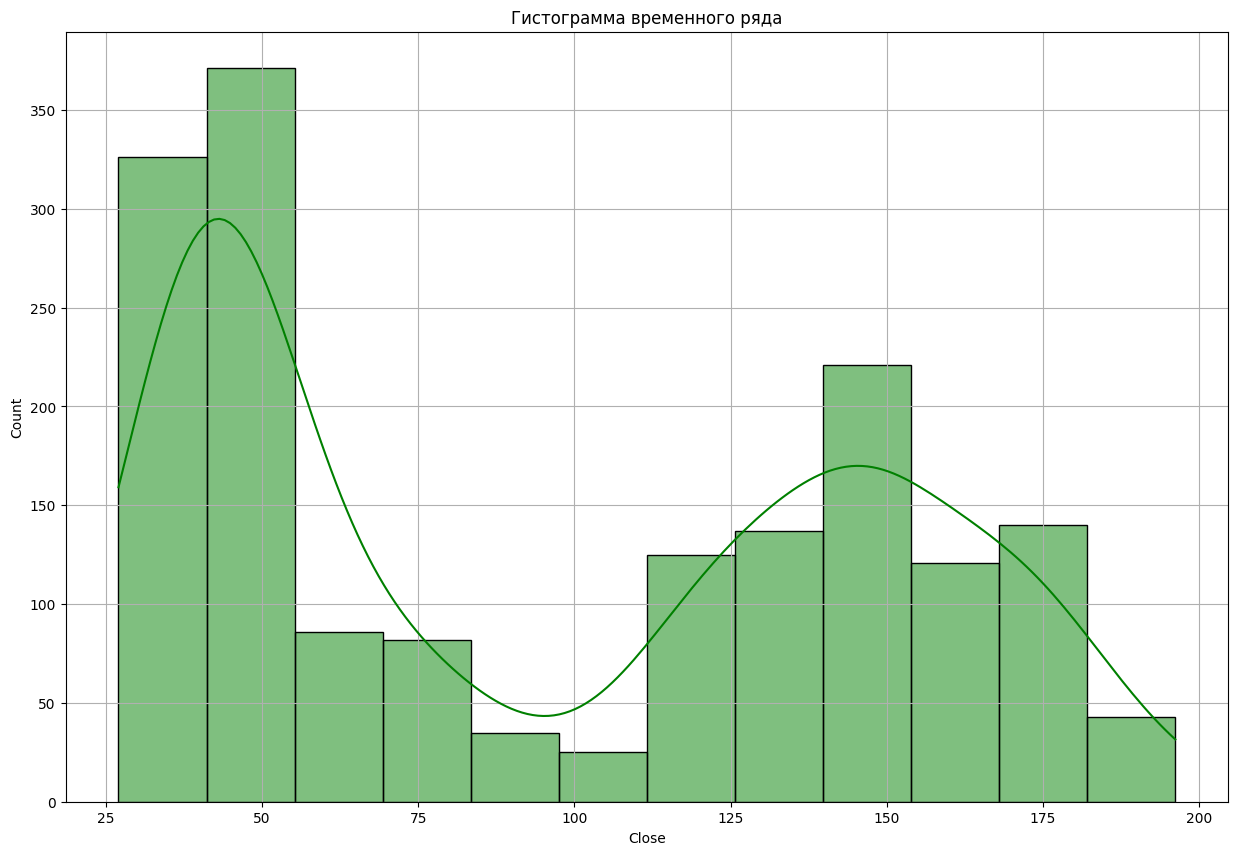

In [34]:
print_result(apple_df['Close'],'green')

Nike time series

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


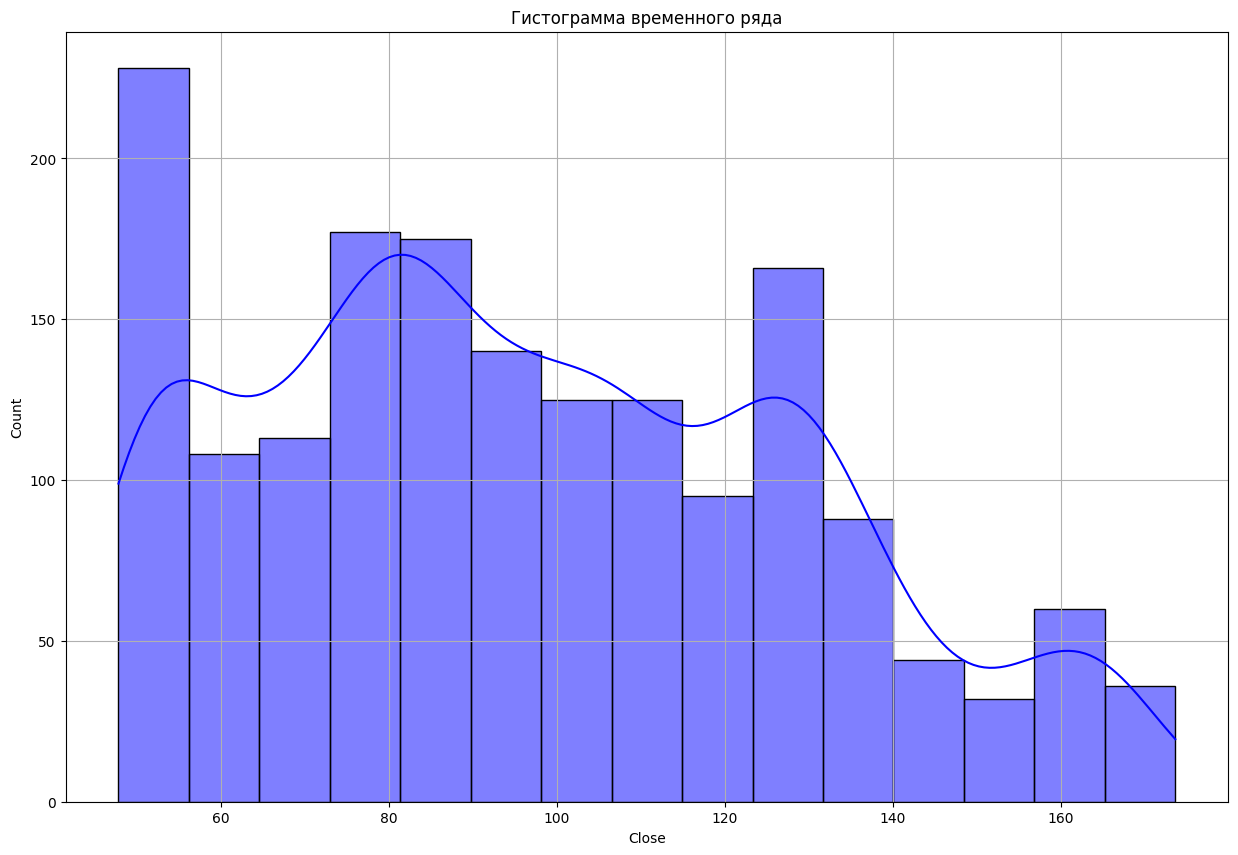

In [35]:
print_result(nike_df['Close'],'blue')

As we can see, according to the test results, the values of the time series are subject to a normal distribution

By applying the Box-Cox transform to the series, the histograms of the series become smoother along the peaks

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


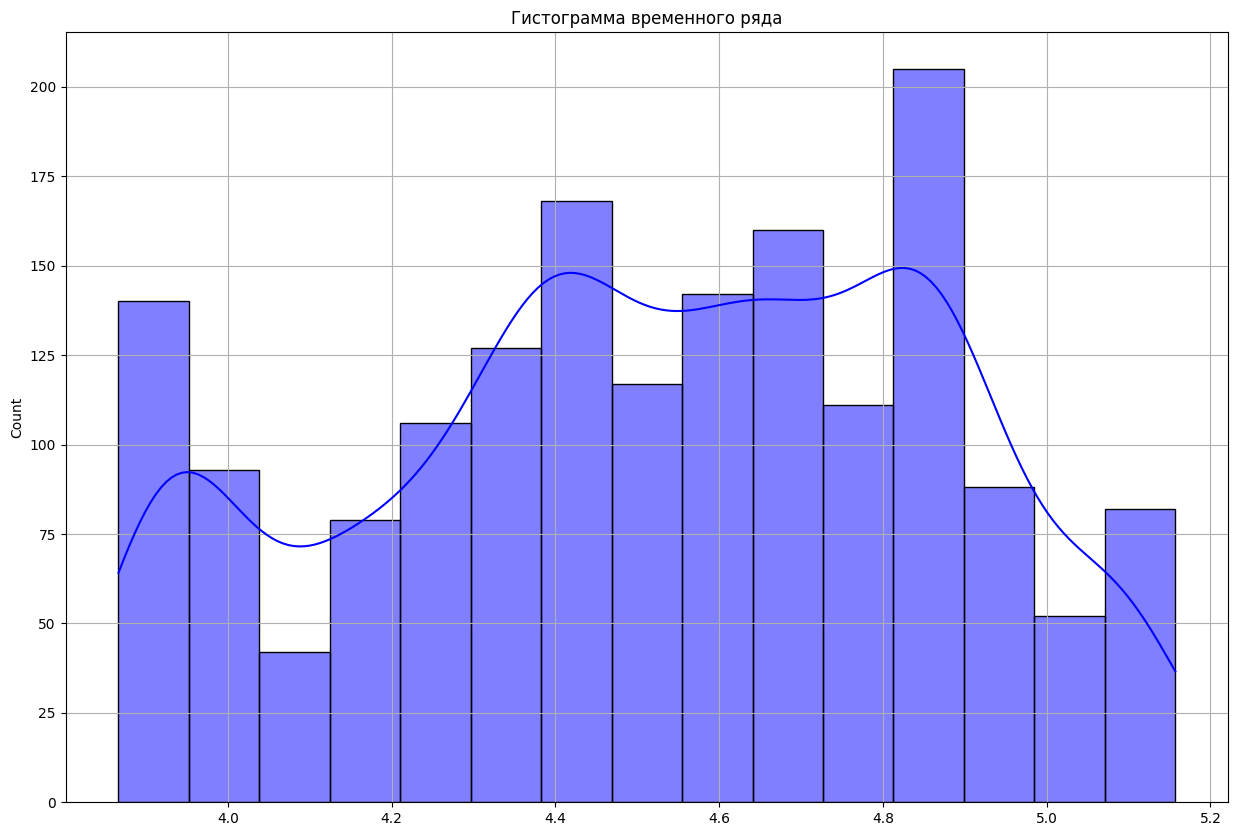

In [36]:
bc = boxcox(nike_df['Close'], 0)
print_result(bc,'blue')

Test1:  Normal
Test2:  Normal
Test3:  Normal
Test4:  Normal
Test5:  Normal


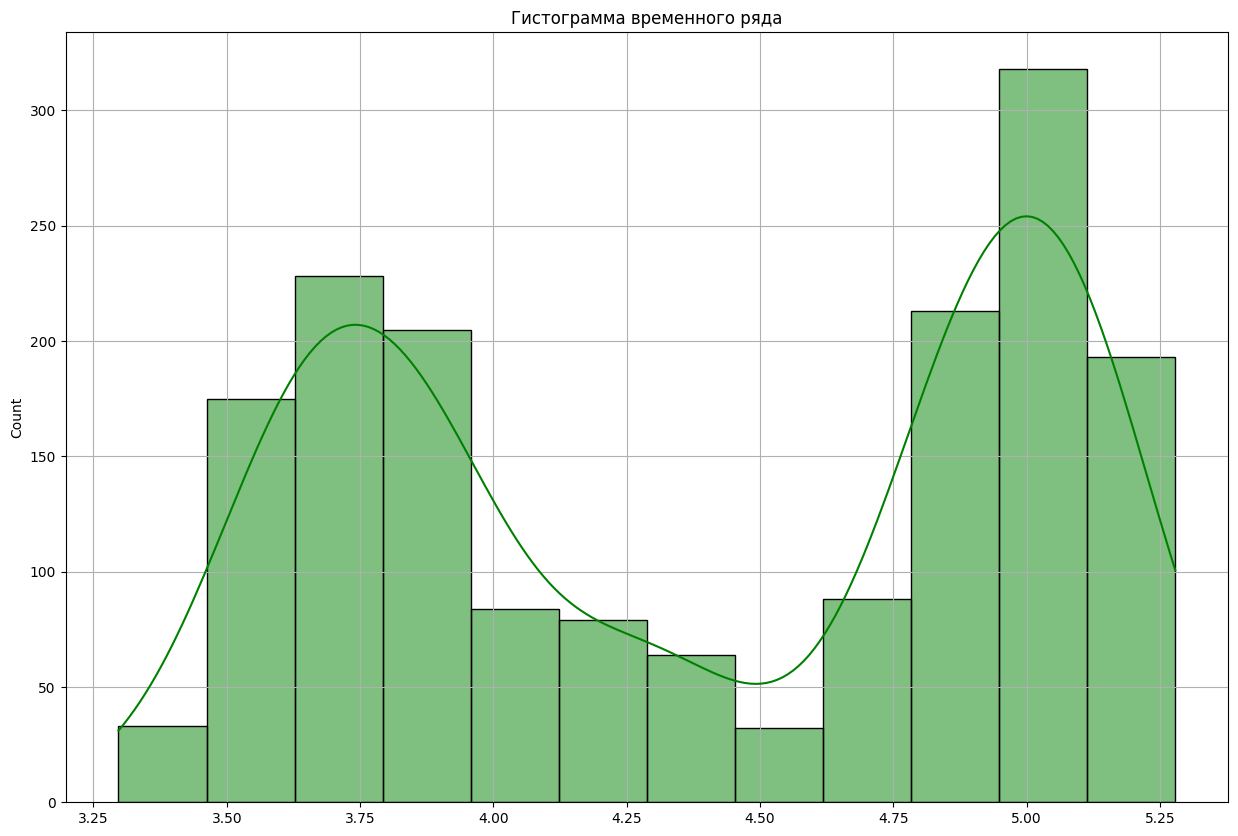

In [37]:
bc = boxcox(apple_df['Close'], 0)
print_result(bc,'green')

### Time series decomposition

In [29]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

ts = apple_df['Close']
ts = ts.asfreq('M')
ts = ts.ffill()

We set the periodicity to a month to smooth out the series and notice characteristics at a distance

In [30]:
ts_decomposed = seasonal_decompose(ts, model='multiplicative')

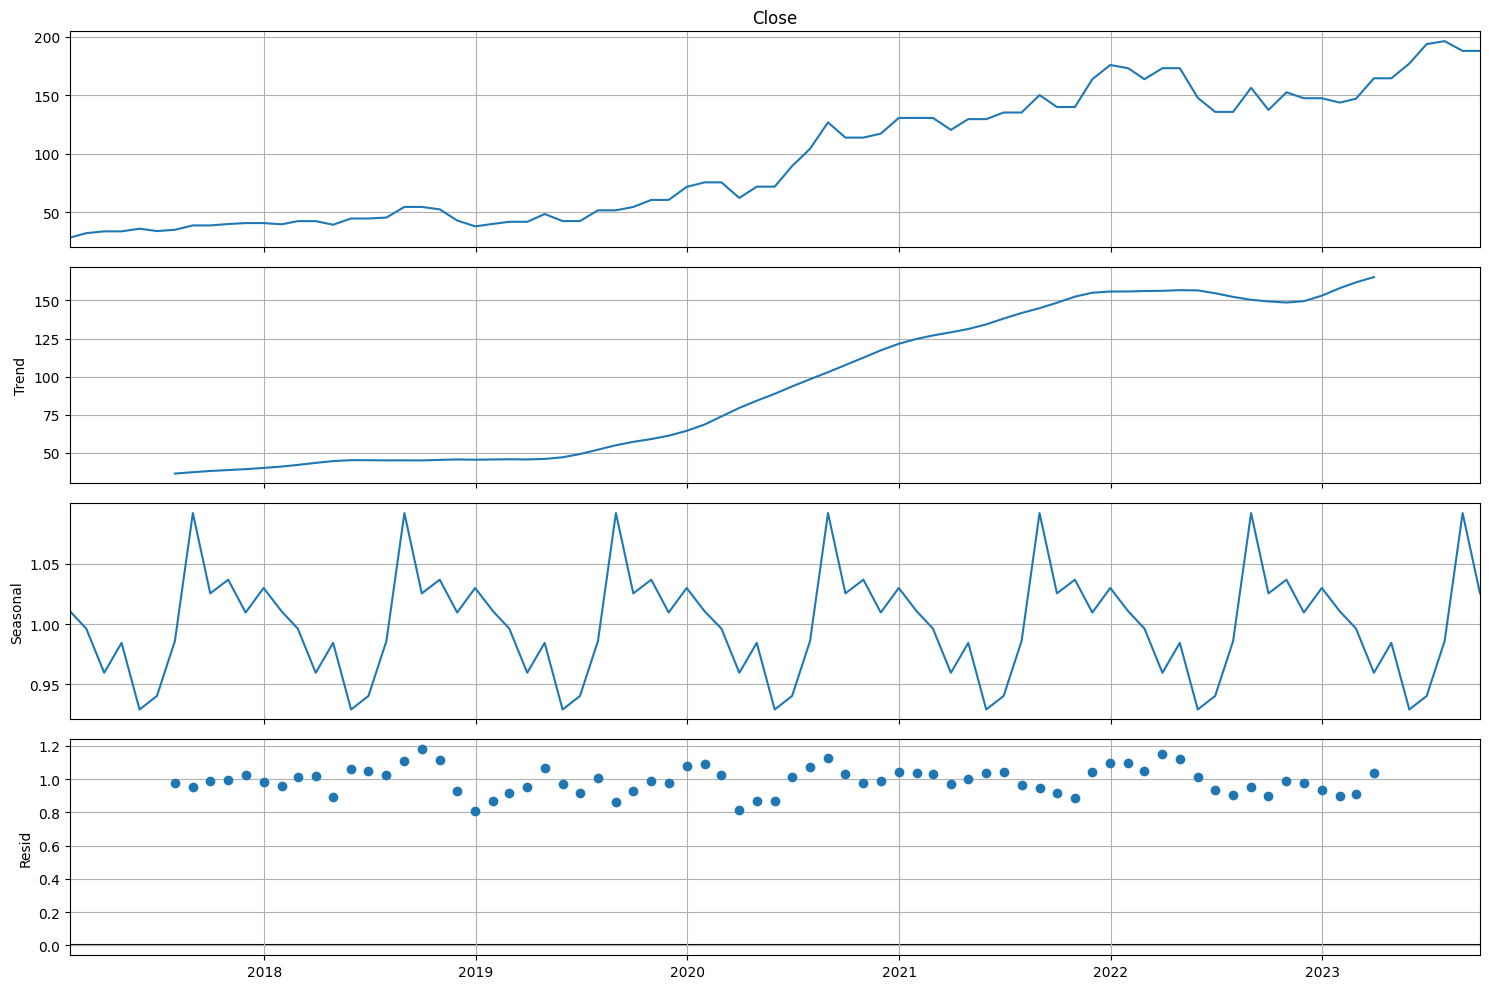

In [31]:
plt.rcParams["figure.figsize"] = [15,10]
plt.rcParams.update({"axes.grid" : True})

ts_decomposed.plot();

Apple's time series has an upward trend over time. Seasonality is determined to be 12 months. It can be seen that after the first quarter, the stock price is at the bottom, and by the end of the second quarter it reaches its maximum.

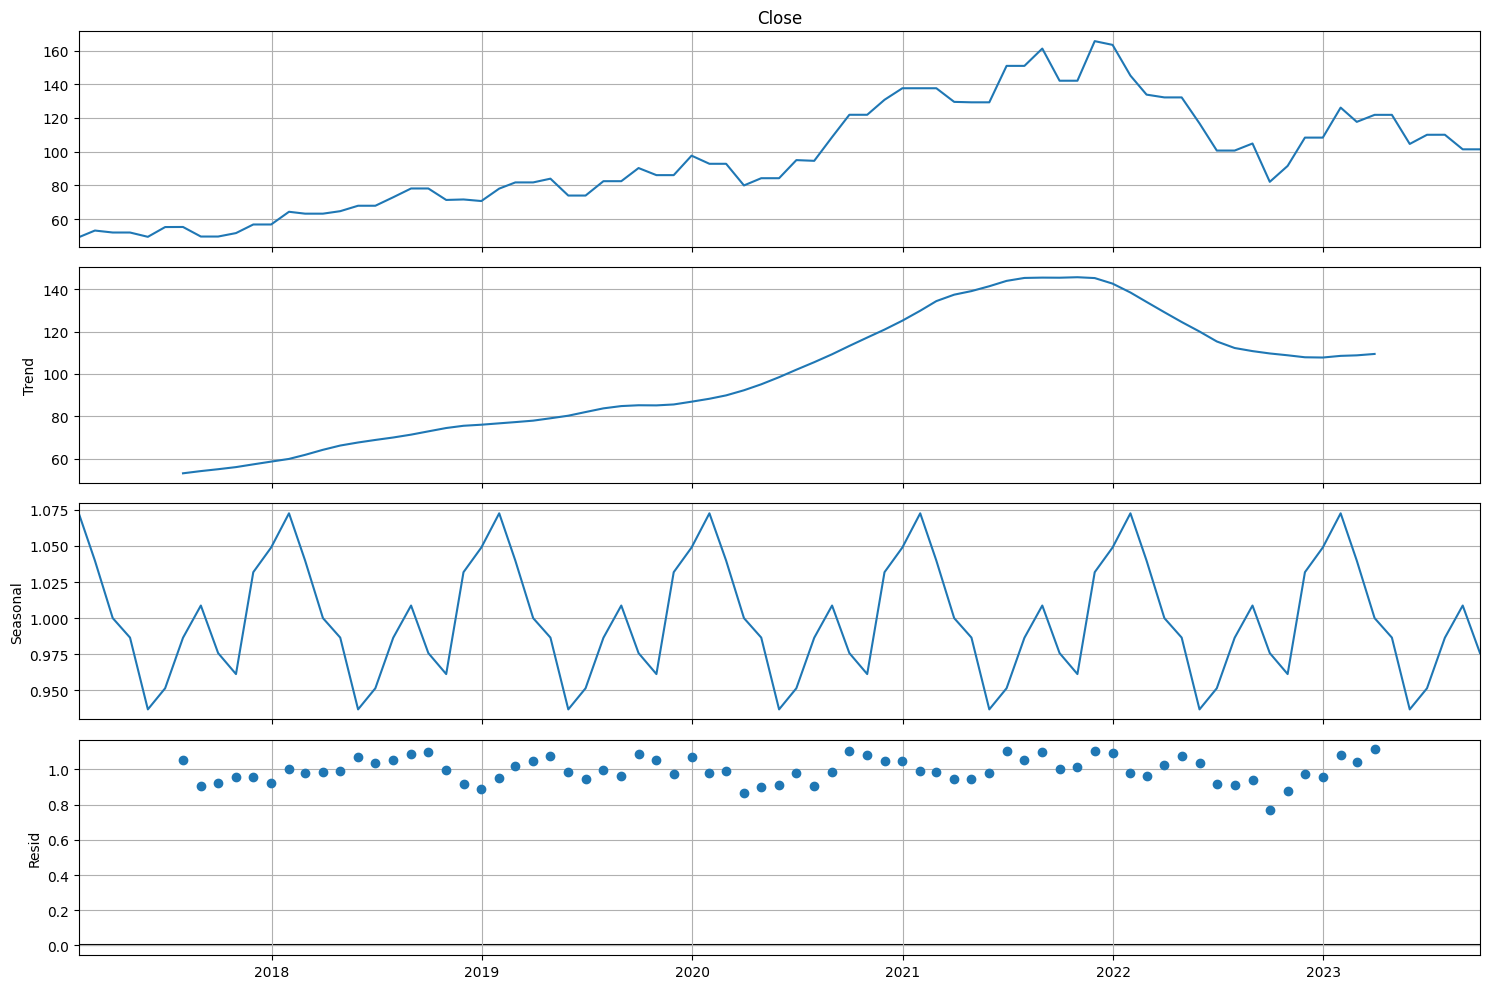

In [32]:
ts = nike_df['Close']
ts = ts.asfreq('M')
ts = ts.ffill()

ts_decomposed = seasonal_decompose(ts, model='multiplicative')
ts_decomposed.plot();

The Nike time series has an upward trend until the beginning of 2022, then there is a bearish trend. A seasonality of 12 months was obtained, it is clear that by the middle of the year shares fall in value.

Summary:
- The original series were not stationary. By applying Box-Cox and first-order differentiation, stationary series were obtained; the Dickey-Fuler test after transformations rejected the hypothesis of nonstationarity.
- According to the results of normality tests, the original time series have normally distributed values.
- After decomposing the time series, we calculated an increasing trend and determined seasonality with a period of 12 months.